# Text classification

- LSTM recurrent neural network model for text classification problem
- Goal: classify whether it is a truly related News or not
- Input data: News title, company name, sector informatin, etc.
- Output data: Y/N for the relateness of company

In [1]:
import numpy as np
import pandas as pd
import os

from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout, Concatenate, concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

### embedding
import spacy

nlp = spacy.load("en_core_web_sm")


In [2]:
news_data = pd.read_csv('News_data_2021_01_27_28.csv', index_col=0)
print('Data dimension: ', news_data.shape)

news_y = [1 if x == 'y' else 0 for x in news_data['label'].tolist()]
print('Number of 1: ', sum(news_y))


Data dimension:  (7007, 7)
Number of 1:  4611


In [3]:
news_data.head()

,published,Date,Symbol,Name,Sector,label,title
0,"Wed, 27 Jan 2021 08:00:00 GMT",2021-01-27,A,Agilent Technologies Inc,Health Care,y,Agilent Technologies: Latest Guidance Increase...
1,"Wed, 27 Jan 2021 08:00:00 GMT",2021-01-27,A,Agilent Technologies Inc,Health Care,y,Global Laboratory Automation Market (2021 to 2...
2,"Wed, 27 Jan 2021 08:00:00 GMT",2021-01-27,A,Agilent Technologies Inc,Health Care,y,Immuno Oncology Assay Market 2021 Business Gro...
3,"Wed, 27 Jan 2021 08:00:00 GMT",2021-01-27,AAP,Advance Auto Parts Inc.,Consumer Discretionary,y,Advance Auto Parts Inc W/I (AAP) Dips 6.15% fo...
4,"Fri, 29 Jan 2021 08:00:00 GMT",2021-01-28,AAPL,Apple Inc,Information Technology,y,Samsung Galaxy S21 vs Apple iPhone 12 - PhoneA...


## Text pre-processing
- convert all text to lower case
- remove News sources
- remove stop words
- remove punctuation

## Modeling preparation
- vectorize each News title/company name/sector, by turning each text into a vector
- Set the max number of words in each News title at 20, each company name at 3, and each sector at 2. 
- Truncate and pad the input sequences so that they are all in the same length for modeling

In [4]:
# Function: tokens to vector
def tokens_to_vectors(max_num_words, tokens, embed_dim):
    vectors = np.zeros((max_num_words, embed_dim)).astype('float32')
    c = min(max_num_words, len(tokens))-1
    end = max_num_words-1
    while c >= 0:
        vectors[end] = tokens[c].vector
        c -= 1
        end -= 1
    return vectors


In [6]:
def get_input_data(tmp_data, name_max_num, sector_max_num, max_words, embed_dim):

    '''
    Company name:
        - 
    '''
    name_tokens = [
        nlp(text.lower()) for text in tmp_data['Name'].tolist()
    ]

    print('Average length of company name: ', 
        np.mean([len(i) for i in name_tokens]))

    name_inputs = []
    for tokens in name_tokens:
        name_inputs.append(
            np.stack(tokens_to_vectors(name_max_num, tokens, len(name_tokens[0][0].vector)))
        )

    '''
    Sector:
        - 
    '''
    sector_tokens = [
        nlp(text.lower()) for text in tmp_data['Sector'].tolist()
    ]

    print('Average length of sector: ', 
        np.mean([len(i) for i in sector_tokens]))

    sector_inputs = []
    for tokens in sector_tokens:
        sector_inputs.append(
            np.stack(tokens_to_vectors(sector_max_num, tokens, len(sector_tokens[0][0].vector)))
        )

    '''
    News title:
        - remove news sources
        - remove stopwords

    '''
    news_all_data = tmp_data['title'].tolist()

    news_input_data = []
    news_source_data = []
    for i in range(len(news_all_data)):
        tmp_list = news_all_data[i].split(' - ')
        if len(tmp_list) > 1:
            news_source_data.append(tmp_list[-1])
            tmp_list = ' - '.join(tmp_list[:-1])
        else:
            news_source_data.append('')
            tmp_list = news_all_data[i]

        news_input_data.append(tmp_list.lower())

    text_tokens = [
        nlp(text) for text in news_input_data
    ]
    # filter掉stopword 和 punct
    filtered_tokens = [
        [token for token in tokens 
         if not token.is_stop 
         and not token.is_punct] for tokens in text_tokens
    ]

    print('50-th and 80-th percentile of the length of titles: ',
        np.quantile([len(i) for i in filtered_tokens], [0.5, 0.8]))


    print('Word embedding vector length:, ', embed_dim)

    print('Length of words in each title: ', max_words)

    '''
        - vector_input: length = max_words*embed_dim 
        - each title: 
            - if length < max_words, pre padding 0s
            - if length > max_words, use the first max_words

    '''
    vector_inputs = []
    for tokens in filtered_tokens:
        vector_inputs.append(
            np.stack(tokens_to_vectors(max_words, tokens, embed_dim))
        )

    print('vector input dimension: ', vector_inputs[0].shape)

    
    '''
        News source:
        - 
    '''
    source_tokens = [
        nlp(text.lower()) for text in news_source_data
    ]
    
    print('Average length of sector: ', 
        np.quantile([len(i) for i in source_tokens], [0.5, 0.9]))

    source_inputs = []
    for tokens in source_tokens:
        source_inputs.append(
            np.stack(tokens_to_vectors(source_max_num, tokens, len(source_tokens[0][0].vector)))
        )    
    
    return name_inputs, sector_inputs, vector_inputs, source_inputs, news_input_data


In [7]:
# Maximum number of words to be used in each case.
name_max_num = 5 # np.ceil(np.mean([len(i) for i in name_tokens]))
sector_max_num = 3 # np.ceil(np.mean([len(i) for i in sector_tokens]))
max_words = 20
source_max_num = 5
# Length of embedding word vector
embed_dim = len(nlp("nike").vector)


In [8]:
name_inputs, \
sector_inputs, \
vector_inputs, \
source_inputs, \
news_input_data = get_input_data(news_data, name_max_num, sector_max_num, 
                                 max_words, embed_dim)


Average length of company name:  2.4451263022691596
Average length of sector:  1.7075781361495648
50-th and 80-th percentile of the length of titles:  [ 9. 12.]
Word embedding vector length:,  96
Length of words in each title:  20
vector input dimension:  (20, 96)
Average length of sector:  [2. 3.]


## LSTM modeling 
- late fusion: three input features pass into three individual lstm model, then combine to get a final output
- early fusion: concatenate three features in the input layer and pass into one lstm model to get the final output


In [9]:
'''
    1. Late fusion

'''
def lstm_late_fusion():
    # input layer
    '''
        News title
    '''
    input_layer = Input(shape=(max_words, embed_dim), 
                        name="input_title")
    lstm_layer = LSTM(100, name="lstm_title")(input_layer) # why 100?

    '''
        Company Name
    '''
    input_company_layer = Input(shape=(name_max_num, embed_dim), 
                                name = 'input_company')
    lstm_company_layer = LSTM(50, name = 'lstm_company')(input_company_layer)

    '''
        Sector
    '''
    input_sector_layer = Input(shape=(sector_max_num, embed_dim), 
                               name = 'input_sector')
    lstm_sector_layer = LSTM(50, name = 'lstm_sector')(input_sector_layer)
    
    '''
        News source
    '''
    input_source_layer = Input(shape=(source_max_num, embed_dim), 
                               name = 'input_source')
    lstm_source_layer = LSTM(50, name = 'lstm_source')(input_source_layer)


    # concatenate layer
    concat_layer = concatenate([lstm_layer, lstm_company_layer, 
                                lstm_sector_layer, lstm_source_layer])

    # dropout layer
    dropout_layer = Dropout(0.5)(concat_layer)

    # fully connected layer
    fc_layer = Dense(50)(dropout_layer)

    # output layer
    out = Dense(
        1,
        activation="sigmoid",
        name="out"
    )(fc_layer)

    model = Model(
        inputs=[input_layer, input_company_layer, 
                input_sector_layer, input_source_layer],
        outputs=out
    )

    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics="accuracy"
    )
    
    return model

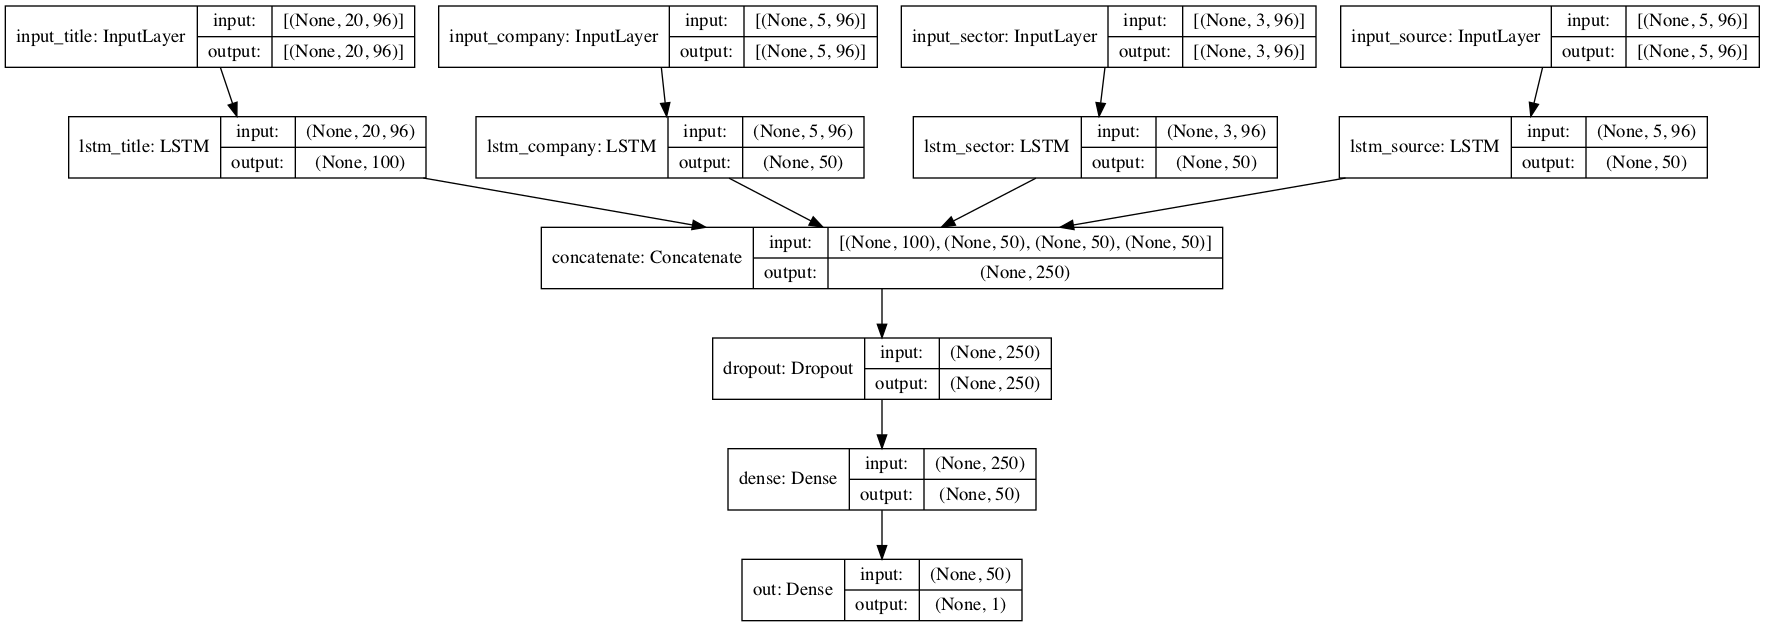

In [10]:
late_model = lstm_late_fusion()

# plot model architecture
plot_model(late_model, to_file="./model_late.png", 
           show_shapes=True, show_layer_names=True)


In [11]:
late_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_title (InputLayer)        [(None, 20, 96)]     0                                            
__________________________________________________________________________________________________
input_company (InputLayer)      [(None, 5, 96)]      0                                            
__________________________________________________________________________________________________
input_sector (InputLayer)       [(None, 3, 96)]      0                                            
__________________________________________________________________________________________________
input_source (InputLayer)       [(None, 5, 96)]      0                                            
______________________________________________________________________________________________

In [12]:
'''
    2. early fusion

'''
def lstm_early_fusion():
    # input layer
    '''
        All: News title + company name + sector + News source
    '''
    input_layer = Input(shape=(max_words+name_max_num+sector_max_num+source_max_num, 
                               embed_dim), 
                        name="input_layer")
    lstm_layer = LSTM(100, name="lstm")(input_layer) # why 100?


    dropout_layer = Dropout(0.5)(lstm_layer)
    fc_layer = Dense(50)(dropout_layer)

    # output layer
    out = Dense(
        1,
        activation="sigmoid",
        name="out"
    )(fc_layer)

    model = Model(
        inputs=input_layer,
        outputs=out
    )

    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics="accuracy"
    )

    return model

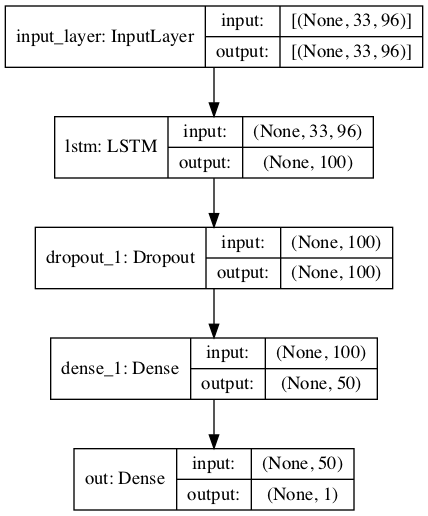

In [13]:
early_model = lstm_early_fusion()

plot_model(early_model, to_file="./model_early.png", 
           show_shapes=True, show_layer_names=True)


In [14]:
early_model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 33, 96)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               78800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
out (Dense)                  (None, 1)                 51        
Total params: 83,901
Trainable params: 83,901
Non-trainable params: 0
_________________________________________________________________


In [15]:
def graph_plots(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()


In [16]:
'''
    - split dataset into: training, validation, testing with 6:2:2
'''
def split_dataset(random_seed, ratio = [0.6, 0.2, 0.2]):
    np.random.seed(random_seed)
    all_index = np.arange(len(news_input_data))
    np.random.shuffle(all_index)
    train_index = all_index[:int(ratio[0]*len(news_input_data))]
    validate_index = all_index[int(ratio[0]*len(news_input_data)):int(sum(ratio[:2])*len(news_input_data))]
    test_index = all_index[int(sum(ratio[:2])*len(news_input_data)):]
    print(len(train_index), len(validate_index), len(test_index), len(all_index))

    return train_index, validate_index, test_index, all_index

In [17]:
# upsampling 0s
def split_dataset_unsampled(random_seed, ratio = [0.6, 0.2, 0.2]):
    i_class0 = np.where(pd.array(news_y) == 0)[0]
    i_class1 = np.where(pd.array(news_y) == 1)[0]

    np.random.seed(random_seed)
    i_class0_upsampled = np.random.choice(i_class0, 
                                          size=len(i_class1), replace=True)

    all_index_unsampled = np.concatenate((i_class0_upsampled, i_class1))
    print(len(all_index_unsampled))
    
    train_index = np.random.choice(all_index_unsampled, 
                                   int(ratio[0]*len(all_index_unsampled)))
    rest_index = np.setdiff1d(all_index_unsampled, train_index)
    validate_index = np.random.choice(rest_index, 
                                     int(ratio[1]*len(all_index_unsampled)))
    rest_index = np.setdiff1d(rest_index, validate_index)
    test_index = np.random.choice(rest_index,
                                 int(ratio[2]*len(all_index_unsampled)))
    print(len(train_index), len(validate_index), 
          len(test_index), len(all_index_unsampled))
    
    return train_index, validate_index, test_index, all_index_unsampled

In [18]:
'''
    1. late fusion
'''
def get_late_fusion_dataset():
    x_train = [np.array(vector_inputs)[train_index], 
               np.array(name_inputs)[train_index],
               np.array(sector_inputs)[train_index],
               np.array(source_inputs)[train_index]]
    y_train = np.array(news_y)[train_index]

    x_validate = [np.array(vector_inputs)[validate_index],
                  np.array(name_inputs)[validate_index],
                  np.array(sector_inputs)[validate_index],
                  np.array(source_inputs)[validate_index]]
    y_validate = np.array(news_y)[validate_index]

    x_test = [np.array(vector_inputs)[test_index],
              np.array(name_inputs)[test_index],
              np.array(sector_inputs)[test_index],
              np.array(source_inputs)[test_index]]

    y_test = np.array(news_y)[test_index]
    
    return x_train, y_train, x_validate, y_validate, x_test, y_test

In [19]:
'''
    Get training, validation and testing datasets
'''

train_index, validate_index, \
test_index, all_index = split_dataset(123456)

x_train_late, y_train_late,\
x_validate_late, y_validate_late, \
x_test_late, y_test_late = get_late_fusion_dataset()

4204 1401 1402 7007


In [20]:
### train model
history_late = late_model.fit(
    x=x_train_late,
    y=y_train_late,
    epochs=10,
    batch_size=32,
    validation_data=(
        x_validate_late,
        y_validate_late,
    )
)


Epoch 1/10
132/132 [==============================] - 9s 28ms/step - loss: 0.5579 - accuracy: 0.7032 - val_loss: 0.2557 - val_accuracy: 0.9079
Epoch 2/10
132/132 [==============================] - 2s 14ms/step - loss: 0.2569 - accuracy: 0.9024 - val_loss: 0.2186 - val_accuracy: 0.9215
Epoch 3/10
132/132 [==============================] - 2s 15ms/step - loss: 0.2050 - accuracy: 0.9229 - val_loss: 0.1733 - val_accuracy: 0.9379
Epoch 4/10
132/132 [==============================] - 2s 15ms/step - loss: 0.1580 - accuracy: 0.9436 - val_loss: 0.1572 - val_accuracy: 0.9422
Epoch 5/10
132/132 [==============================] - 2s 17ms/step - loss: 0.1166 - accuracy: 0.9554 - val_loss: 0.1579 - val_accuracy: 0.9465
Epoch 6/10
132/132 [==============================] - 2s 14ms/step - loss: 0.0808 - accuracy: 0.9708 - val_loss: 0.1491 - val_accuracy: 0.9507
Epoch 7/10
132/132 [==============================] - 2s 16ms/step - loss: 0.0633 - accuracy: 0.9787 - val_loss: 0.1629 - val_accuracy: 0.9436

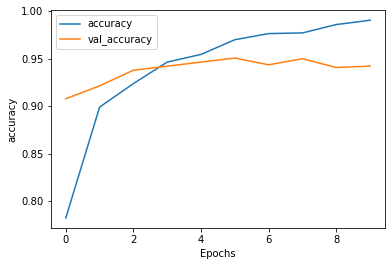

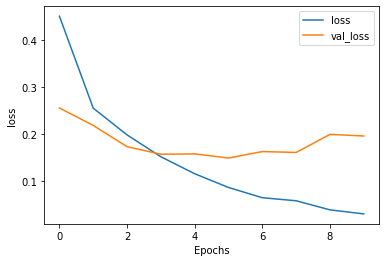

In [21]:
graph_plots(history_late, "accuracy")
graph_plots(history_late, "loss")


In [22]:
predict_test_late = late_model.predict(x_test_late)

y_test_pred_late = [x[0] for x in (predict_test_late > 0.5).astype(np.int32)]
test_acc_late = (y_test_late == y_test_pred_late).sum()/len(y_test_late)

print("TEST accuracy: {}".format(test_acc_late))


TEST accuracy: 0.9415121255349501


The reported averages include macro average (averaging the unweighted mean per label), weighted average (averaging the support-weighted mean per label), and sample average (only for multilabel classification).

In [23]:
report_late = classification_report(y_test_late, y_test_pred_late, output_dict=True)
report_late


{'0': {'precision': 0.9109311740890689,
  'recall': 0.9221311475409836,
  'f1-score': 0.9164969450101833,
  'support': 488},
 '1': {'precision': 0.9581497797356828,
  'recall': 0.9518599562363238,
  'f1-score': 0.9549945115257958,
  'support': 914},
 'accuracy': 0.9415121255349501,
 'macro avg': {'precision': 0.9345404769123759,
  'recall': 0.9369955518886537,
  'f1-score': 0.9357457282679895,
  'support': 1402},
 'weighted avg': {'precision': 0.941714202306619,
  'recall': 0.9415121255349501,
  'f1-score': 0.9415945026387638,
  'support': 1402}}

In [24]:
'''
    2. early fusion
'''
def get_early_fusion_dataset():
    
    all_inputs = [np.concatenate((vector_inputs[i], name_inputs[i], 
                                  sector_inputs[i], source_inputs[i]))
                     for i in range(len(vector_inputs))]
    print(len(all_inputs), all_inputs[0].shape)

    x_train = np.array(all_inputs)[train_index]
    y_train = np.array(news_y)[train_index]

    x_validate = np.array(all_inputs)[validate_index]
    y_validate = np.array(news_y)[validate_index]

    x_test = np.array(all_inputs)[test_index]

    y_test = np.array(news_y)[test_index]

    return x_train, y_train, x_validate, y_validate, x_test, y_test

In [25]:
x_train_early, y_train_early,\
x_validate_early, y_validate_early, \
x_test_early, y_test_early = get_early_fusion_dataset()

7007 (33, 96)


In [ ]:
### train model
history_early = early_model.fit(
    x=x_train_early,
    y=y_train_early,
    epochs=10,
    batch_size=32,
    validation_data=(
        x_validate_early,
        y_validate_early,
    )
)


Epoch 1/10
132/132 [==============================] - 4s 20ms/step - loss: 0.6083 - accuracy: 0.6601 - val_loss: 0.3635 - val_accuracy: 0.8408
Epoch 2/10
132/132 [==============================] - 2s 18ms/step - loss: 0.3199 - accuracy: 0.8709 - val_loss: 0.2151 - val_accuracy: 0.9222
Epoch 3/10
132/132 [==============================] - 2s 18ms/step - loss: 0.2042 - accuracy: 0.9233 - val_loss: 0.1821 - val_accuracy: 0.9365
Epoch 4/10
132/132 [==============================] - 3s 20ms/step - loss: 0.1505 - accuracy: 0.9470 - val_loss: 0.1843 - val_accuracy: 0.9358
Epoch 5/10
 88/132 [===================>..........] - ETA: 0s - loss: 0.0919 - accuracy: 0.9697

In [ ]:
graph_plots(history_early, "accuracy")
graph_plots(history_early, "loss")


In [ ]:
predict_test_early = early_model.predict(x_test_early)

y_test_pred_early = [x[0] for x in (predict_test_early > 0.5).astype(np.int32)]
test_acc_early = (y_test_early == y_test_pred_early).sum()/len(y_test_early)

print("TEST accuracy: {}".format(test_acc_early))


In [ ]:
report_early = classification_report(y_test_early, y_test_pred_early, output_dict=True)
report_early
